In [90]:
import sys
import os
# add parent directory (where "natsume" lives) to sys.path so I can import natsume
sys.path.append(r"C:\Users\WBS\Desktop\EXOPLANET WORK\006 NATSUME")
import natsume

import ttv_curvefit.curvefit as ttvfit  # custom-written
import ttvfast
from ttvfast import models

import pandas as pd
import numpy as np
from astropy import units as u
from astropy.constants import M_earth
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import tqdm

This file aims to create TTV signals to validate 1st order MMR code with regimes
- Eccentricities: 0.001 to 0.1 / Uniform log e
- Longitudes of periastron: 0 to 90 deg / Uniform w
- MMRs: 2:1, 3:2, 4:3, 5:4 / Uniform
- |Deltas|: 0.01 to 0.1 / Uniform
- Planet masses: 0.3 to 3000 Earth masses / Uniform log m

If system with invalid regime e >~ Delta^2 / mu is detected, then DO NOT SIMULATE.

In [93]:
# Create 15000 samples
size = 15000
mstar = 1

e1 = 10 ** np.random.uniform(low=-3, high=-1, size=size)
e2 = 10 ** np.random.uniform(low=-3, high=-1, size=size)
w1 = np.random.uniform(low=0, high=90, size=size)
w2 = np.random.uniform(low=0, high=90, size=size)

Delta = np.random.uniform(low=0.01, high=0.1, size=size) * np.random.choice([-1, 1], size=size)
j = np.random.choice([2, 3, 4, 5], size=size)
P1 = 7
P2 = P1 * (Delta + 1) * j / (j-1)

m1 = 10 ** np.random.uniform(low=-0.5, high=3.5, size=size)
m2 = 10 ** np.random.uniform(low=-0.5, high=3.5, size=size)

mu1 = (m1 * u.M_earth).to(mstar * u.M_sun).value
mu2 = (m2 * u.M_earth).to(mstar * u.M_sun).value

validity1 = Delta**2 / (mu1 * e1)
validity2 = Delta**2 / (mu2 * e2)
validity_threshold = 100

# Create valid mask
valid = (validity1 > validity_threshold) & (validity2 > validity_threshold)
valid_percent = valid.mean() * 100

# Compile to dataframe
df = pd.DataFrame({
    'e1': e1, 'w1': w1,
    'e2': e2, 'w2': w2,
    'Delta': Delta, 'j': j,
    'P1': 7, 'P2': P2,
    'm1': m1, 'm2': m2,
    'mu1': mu1, 'mu2': mu2,
    'validity1': validity1, 'validity2': validity2,
    'valid': valid
})
df.head()

,e1,w1,e2,w2,Delta,j,P1,P2,m1,m2,mu1,mu2,validity1,validity2,valid
0,0.006900,22.878221,0.085828,57.891198,-0.033844,5,7,8.453867,1.345331,353.241274,0.000004,0.001061,41082.301486,12.578575,False
1,0.001356,89.298503,0.001144,87.310923,0.034637,4,7,9.656608,177.595738,7.061223,0.000533,0.000021,1658.606847,49458.851467,True
2,0.001231,18.064109,0.002705,22.154587,-0.026507,2,7,13.628900,674.637818,742.365014,0.002026,0.002230,281.728353,116.496319,True
3,0.016555,8.010640,0.034746,50.908861,0.082842,3,7,11.369840,1.647885,3.817003,0.000005,0.000011,83758.155781,17228.363158,True
4,0.044498,71.030538,0.003897,86.017694,-0.057276,4,7,8.798762,148.807725,297.743600,0.000447,0.000894,164.948686,941.318268,True


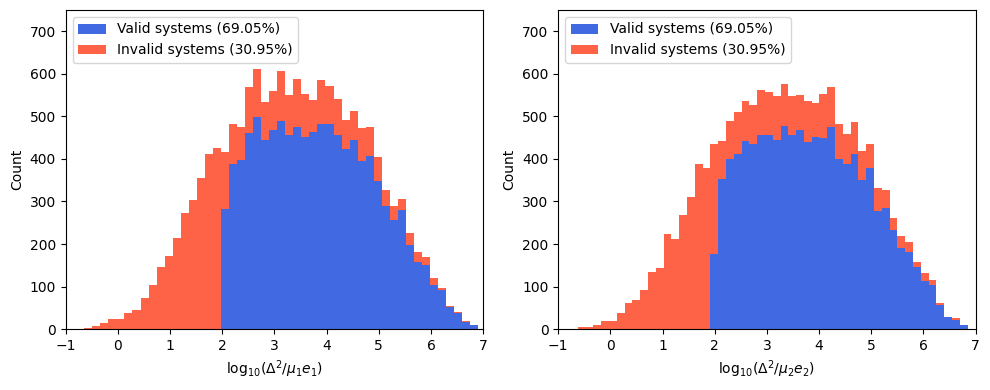

In [96]:
# Histogram of validity condition
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
fmt = lambda x: f"{x:.2f}".rstrip("0").rstrip(".")
labels = [f"Valid systems ({fmt(valid_percent)}%)", f"Invalid systems ({fmt(100-valid_percent)}%)"]
colors = ["royalblue", "tomato"]
xlim = (-1, 7); ylim = (0, 750)

# Left histogram
ax[0].hist([np.log10(validity1[valid]), np.log10(validity1[~valid])],
           bins=50, stacked=True, label=labels, color=colors)
ax[0].set_xlabel('log$_{10}$($\Delta^2 / \mu_1 e_1$)')
ax[0].set_ylabel('Count')
ax[0].set_xlim(xlim); ax[0].set_ylim(ylim)
ax[0].legend(loc='upper left')

# Right histogram
ax[1].hist([np.log10(validity2[valid]), np.log10(validity2[~valid])],
           bins=50, stacked=True, label=labels, color=colors)
ax[1].set_xlabel('log$_{10}$($\Delta^2 / \mu_2 e_2$)')
ax[1].set_ylabel('Count')
ax[1].set_xlim(xlim); ax[1].set_ylim(ylim)
ax[1].legend(loc='upper left')

plt.tight_layout()
plt.show()

In [97]:
# Export dataframe
df.to_csv("lithwick_TTVFast_params.csv", index=False)